# Die Stimmungserkennung (SER)

## Inhalt

* [Tensorboard](#Tensorboard)
* [Python-Bibliotheken](#Bibliotheken)
* [Die Vorverarbeitung](#Vorverarbeitung)  
    * [Die Datenbeladung](#Datenbeladung)    
    * [Die Datenvisualisierung](#datenvisual)
* [Das Klassifikationsmodell](#klassifikationsmodell)
    * [Die Modellskonfiguration](#modelskonfiguration)
    * [Die Modellstruktur](#modellstruktur)
    * [Modell-Training](#modelltraining)
* [Save Modell](#savemodell)
* [Test Modell](#testmodell)
    * [Die Ganauigkeit](#ganauigkeit)
    * [Die Metriken](#metriken)

## Tensorboard<a class="anchor" id="Tensorboard"></a>

#### Tensorboard ist eine Webanwendung zur Visualisierungverschidener Aspekte neuronaler Netze

In [ ]:
from keras.backend import clear_session
clear_session()
%reload_ext tensorboard

## Python-Bibliotheken<a class="anchor" id="Bibliotheken"></a>

In [1]:
import torch
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from torchvision import models, transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision
from functools import partial
import keras
import itertools
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from google.colab import drive
import os

## Die Vorverarbeitung<a class="anchor" id="Vorverarbeitung"></a>

In [2]:
# "surprise" wird von 8 auf 0 geändert
EMOTIONS = {0:'neutral', 1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'surprise'} 

In [3]:
# Audiodateien

drive.mount('/content/drive')


os.chdir('drive/My Drive')
gdrive_path = os.getcwd()

Mounted at /content/drive


In [4]:
path_model = Path.cwd() / "ravdess" / "modell" / "path_model_cross_val_RGB.h5"
PATH_TO_RAVDESS = Path.cwd() /"frequenzbereich"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS / "train"
bs = 1440

In [5]:
# Confusion Matrix
class_names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix (Keras ResNet - Modell)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Die Datenbeladung<a class="anchor" id="Datenbeladung"></a>

In [6]:
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')# convert image to (YCbCr)YUL
        return (self.img_transforms(img), label)

            
    def __len__(self):
        return self.length

In [7]:
def LoadRavdess():

    ravdess = PrecomputedRavdess(PATH_RAVDESS_TRAIN,
                                  img_transforms=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])]))



    ravdess_loader = torch.utils.data.DataLoader(ravdess, bs, shuffle=True)

    spectogram = torch.utils.data.DataLoader(ravdess,64,shuffle=True )         
    return ravdess_loader, spectogram

In [8]:
ravdess_loader,spectogram = LoadRavdess()

### Die Datenvisualisierung<a class="anchor" id="#datenvisual"></a>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Labels: tensor([2, 5, 0, 5, 5, 1, 4, 3, 0, 3, 0, 0, 3, 3, 2, 4, 3, 0, 0, 0, 1, 0, 0, 0,
        5, 2, 0, 5, 2, 2, 4, 5, 1, 4, 3, 1, 3, 4, 2, 0, 1, 0, 4, 0, 0, 0, 1, 1,
        0, 2, 3, 5, 4, 4, 5, 3, 5, 4, 3, 3, 4, 3, 3, 4])


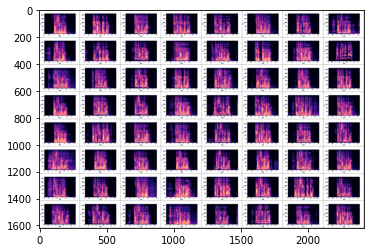

In [9]:
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
img, label = next(iter(spectogram))       
images, labels = next(iter(ravdess_loader))  

print("Train Labels:",label)
imshow(torchvision.utils.make_grid(img)/2)

In [10]:
labels.shape

torch.Size([1151])

In [11]:
# Cross-validate
kf = StratifiedKFold(5, shuffle=True,random_state=42)

## Das Klassifikationsmodell<a class="anchor" id="#klassifikationsmodell"></a>

### Die Modellskonfiguration<a class="anchor" id="#modelskonfiguration"></a>

In [12]:
batch_size = 64
img_width, img_height, img_num_channels = 3,200,300
loss_function = sparse_categorical_crossentropy
no_classes = 6
optimizer = Adam()
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [13]:
# Residual Unit-Schicht
# Im Konstruktor werden alle erforderlichen Schichten erzeugt
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [14]:
#Das ResNet-34 kann mit einem Sequential-Modell angebaut werden.
def build_model():
    model = keras.models.Sequential()
    model.add(DefaultConv2D(64, kernel_size=3, strides=1,
                        input_shape= input_shape ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 7
    for filters in [64] * 1 + [128] * 1 + [256] * 1: 
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(no_classes, activation="softmax"))
    optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
    model.compile(loss=loss_function,
              optimizer=optimizer,  metrics=['accuracy'])
    return model

In [15]:
# Datentyp-Umwandelung
images = (tf.cast(images, tf.float32) / 255).numpy()
labels = labels.numpy()


### Die Modellstruktur<a class="anchor" id="#modellstruktur"></a>

In [16]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 200, 64)        172800    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 200, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 3, 200, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 100, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 1, 50, 64)         78592     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 1, 25, 128)        230912    
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 1, 13, 256)        9

Fold #1
Epoch 1/50
15/15 [==============================] - 38s 1s/step - loss: 1.7273 - accuracy: 0.3148 - val_loss: 1.7939 - val_accuracy: 0.1645
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 1.4643 - accuracy: 0.4066 - val_loss: 1.8069 - val_accuracy: 0.1645
Epoch 3/50
15/15 [==============================] - 17s 1s/step - loss: 1.1285 - accuracy: 0.5553 - val_loss: 1.8353 - val_accuracy: 0.1645
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.9780 - accuracy: 0.6403 - val_loss: 1.8788 - val_accuracy: 0.1645
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.7778 - accuracy: 0.7183 - val_loss: 1.9610 - val_accuracy: 0.1645
Epoch 6/50
15/15 [==============================] - 17s 1s/step - loss: 0.6634 - accuracy: 0.7620 - val_loss: 2.0273 - val_accuracy: 0.1645
Epoch 7/50
15/15 [==============================] - 17s 1s/step - loss: 0.5985 - accuracy: 0.7776 - val_loss: 2.0572 - val_accuracy: 0.1645
Epoch 8/50
1

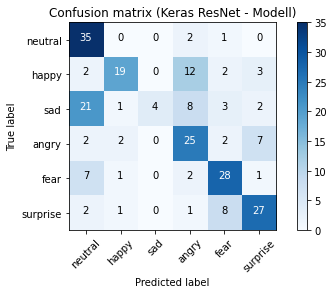

Fold score (accurancy): 0.5974025974025974
Fold #2
Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 0.6138 - accuracy: 0.7980 - val_loss: 7.3191 - val_accuracy: 0.2522
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 0.4758 - accuracy: 0.8588 - val_loss: 13.0628 - val_accuracy: 0.3000
Epoch 3/50
15/15 [==============================] - 19s 1s/step - loss: 0.2075 - accuracy: 0.9316 - val_loss: 3.2663 - val_accuracy: 0.6000
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.1173 - accuracy: 0.9609 - val_loss: 5.8029 - val_accuracy: 0.3217
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.0498 - accuracy: 0.9935 - val_loss: 4.0120 - val_accuracy: 0.3957
Epoch 6/50
15/15 [==============================] - 17s 1s/step - loss: 0.0198 - accuracy: 0.9957 - val_loss: 4.3621 - val_accuracy: 0.3565
Epoch 7/50
15/15 [==============================] - 17s 1s/step - loss: 0.0342 - accuracy: 0.9924 - val_loss

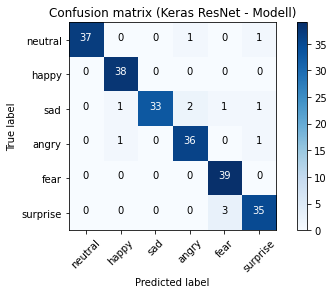

Fold score (accurancy): 0.9478260869565217
Fold #3
Epoch 1/50
15/15 [==============================] - 21s 1s/step - loss: 0.3138 - accuracy: 0.8893 - val_loss: 23.5217 - val_accuracy: 0.1696
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 0.4892 - accuracy: 0.8230 - val_loss: 44.5075 - val_accuracy: 0.1783
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.2090 - accuracy: 0.9240 - val_loss: 18.0607 - val_accuracy: 0.2304
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.1058 - accuracy: 0.9685 - val_loss: 9.7442 - val_accuracy: 0.2565
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.0444 - accuracy: 0.9891 - val_loss: 5.2057 - val_accuracy: 0.3652
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.0372 - accuracy: 0.9913 - val_loss: 5.1396 - val_accuracy: 0.4043
Epoch 7/50
15/15 [==============================] - 18s 1s/step - loss: 0.0435 - accuracy: 0.9870 - val_lo

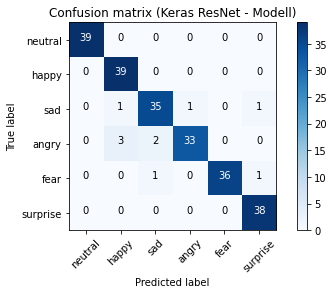

Fold score (accurancy): 0.9565217391304348
Fold #4
Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 0.0897 - accuracy: 0.9718 - val_loss: 2.0395 - val_accuracy: 0.6565
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 0.3112 - accuracy: 0.8871 - val_loss: 2.2032 - val_accuracy: 0.5783
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.1989 - accuracy: 0.9381 - val_loss: 9.4178 - val_accuracy: 0.3391
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.0980 - accuracy: 0.9609 - val_loss: 12.6175 - val_accuracy: 0.1696
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.0397 - accuracy: 0.9902 - val_loss: 11.1981 - val_accuracy: 0.2435
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.0348 - accuracy: 0.9902 - val_loss: 9.5416 - val_accuracy: 0.2043
Epoch 7/50
15/15 [==============================] - 18s 1s/step - loss: 0.0435 - accuracy: 0.9891 - val_los

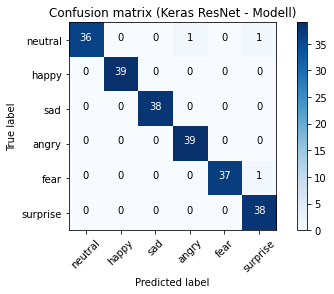

Fold score (accurancy): 0.9869565217391304
Fold #5
Epoch 1/50
15/15 [==============================] - 18s 1s/step - loss: 0.0735 - accuracy: 0.9718 - val_loss: 4.6048 - val_accuracy: 0.5087
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 0.2611 - accuracy: 0.9131 - val_loss: 11.1576 - val_accuracy: 0.2696
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.2678 - accuracy: 0.9034 - val_loss: 9.1531 - val_accuracy: 0.1696
Epoch 4/50
15/15 [==============================] - 17s 1s/step - loss: 0.1023 - accuracy: 0.9674 - val_loss: 5.5423 - val_accuracy: 0.3304
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.0789 - accuracy: 0.9718 - val_loss: 3.2341 - val_accuracy: 0.4913
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.0244 - accuracy: 0.9946 - val_loss: 3.1448 - val_accuracy: 0.5957
Epoch 7/50
15/15 [==============================] - 19s 1s/step - loss: 0.0139 - accuracy: 0.9946 - val_loss

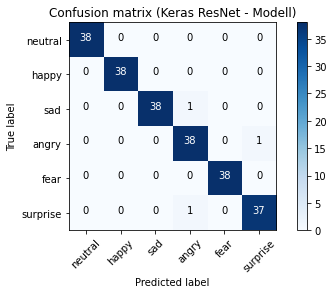

Fold score (accurancy): 0.9869565217391304
Finale score (accurancy): 0.894874022589053


In [17]:
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(images, labels):
  fold+=1
  print(f"Fold #{fold}")

  x_train = images[train]
  y_train = labels[train]

  x_test = images[test]
  y_test = labels[test]
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=50,        
            verbose=verbosity,
            validation_data = (x_test, y_test))
  y_pred = model.predict(x_test, batch_size=64, verbose=1)
  y_pred_b = np.argmax(y_pred, axis=1)

  print(classification_report(y_test, y_pred_b))
  
  plt.figure()
  plot_confusion_matrix(confusion_matrix(y_test, y_pred_b), classes=class_names)
  plt.show()

  pred = model.predict(x_test)

  oos_y.append(y_test)
  pred = np.argmax(pred,axis=1)
  oos_pred.append(pred)

  score = metrics.accuracy_score(y_test,pred)
  print(f"Fold score (accurancy): {score}")

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)


score = metrics.accuracy_score(oos_y, oos_pred)
print(f"Finale score (accurancy): {score}")



## Save Modell<a class="anchor" id="#savemodell"></a>

In [18]:
model.save_weights(path_model)